In [1]:
import requests
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from config import api_key
import scipy.stats as scipy

g_url = 'https://maps.googleapis.com/maps/api/geocode/json?&address='
fifa_url = 'https://worldcup.sfg.io/teams/results'

In [2]:
#request data on all the teams in the 2018 World cup
response = requests.get(fifa_url).json()
teams_df = pd.DataFrame(response)
teams_df.head(2)

,alternate_name,country,draws,fifa_code,games_played,goal_differential,goals_against,goals_for,group_id,group_letter,id,losses,points,wins
0,None,Korea Republic,0,KOR,3,0,3,3,6,F,24,2,3,1
1,None,Germany,0,GER,3,-2,4,2,6,F,21,2,3,1


In [3]:
#set country as index delete alternate_name series
teams_df.index = teams_df["country"]
del teams_df["alternate_name"]
teams_df.head(2)

,country,draws,fifa_code,games_played,goal_differential,goals_against,goals_for,group_id,group_letter,id,losses,points,wins
country,,,,,,,,,,,,,
Korea Republic,Korea Republic,0,KOR,3,0,3,3,6,F,24,2,3,1
Germany,Germany,0,GER,3,-2,4,2,6,F,21,2,3,1


In [4]:
# import other data, create DF
matches_url = "https://worldcup.sfg.io/matches"
match_df = pd.DataFrame(requests.get(matches_url).json())
match_df.head(2)

,attendance,away_team,away_team_country,away_team_events,away_team_statistics,datetime,fifa_id,home_team,home_team_country,home_team_events,...,last_score_update_at,location,officials,stage_name,status,time,venue,weather,winner,winner_code
0,78011,"{'country': 'Saudi Arabia', 'code': 'KSA', 'go...",Saudi Arabia,"[{'id': 12, 'type_of_event': 'substitution-in'...","{'country': 'Saudi Arabia', 'attempts_on_goal'...",2018-06-14T15:00:00Z,300331503,"{'country': 'Russia', 'code': 'RUS', 'goals': ...",Russia,"[{'id': 5, 'type_of_event': 'goal', 'player': ...",...,None,Luzhniki Stadium,"[Nestor PITANA, Hernan MAIDANA, Juan Pablo BEL...",First stage,completed,full-time,Moscow,"{'humidity': '43', 'temp_celsius': '17', 'temp...",Russia,RUS
1,27015,"{'country': 'Uruguay', 'code': 'URU', 'goals':...",Uruguay,"[{'id': 15, 'type_of_event': 'substitution-in'...","{'country': 'Uruguay', 'attempts_on_goal': 14,...",2018-06-15T12:00:00Z,300353632,"{'country': 'Egypt', 'code': 'EGY', 'goals': 0...",Egypt,"[{'id': 14, 'type_of_event': 'substitution-in'...",...,None,Ekaterinburg Arena,"[Bjorn KUIPERS, Sander VAN ROEKEL, Erwin ZEINS...",First stage,completed,full-time,Ekaterinburg,"{'humidity': '42', 'temp_celsius': '14', 'temp...",Uruguay,URU


In [5]:
# set up dicts for goal_times per stage
goal_times_dict = {
    'First stage':{},
    'Round of 16':{},
    'Quarter-finals': {},
    'Semi-finals': {},
    'Play-off for third place':{},
    'Final':{} 
}

# create empty DF for ?
goal_times_means = pd.DataFrame()

# loop through data to get ?
for index, match in match_df.iterrows():
    
    # variables for 
    home = match['home_team_country']
    away = match['away_team_country']
    home_event = match['home_team_events']
    away_event = match['away_team_events']
    team_events = [home_event, away_event]
    teams = [home, away]
    goal_times = goal_times_dict[match['stage_name']]
    
    
    for events in team_events:
        team = teams[team_events.index(events)]
        for event in events: 
            if (event['type_of_event'] == 'goal'):
                time = event['time']
                time = time.replace("'", "")
                
                try:
                    time = int(time)
                except:
                    time = eval(time)
                    
                if team in goal_times:
                    goal_times[team].append(time)
                else:
                    goal_times[team] = []
                    goal_times[team].append(time)
            else:
                continue

for stage in goal_times_dict:
    for country in goal_times_dict[stage]:
        goal_times_means.loc[country, stage] = np.mean(goal_times_dict[stage][country])

In [6]:
combined_avg = []

for x in range(len(goal_times_means)):
    temp_avg = goal_times_means.iloc[x].dropna()
    temp_avg = temp_avg.mean()
    combined_avg.append(temp_avg)
    
goal_times_means["combined_avg"] = combined_avg

In [7]:
reindexed_combined_df = goal_times_means.reset_index()
reindexed_combined_df = reindexed_combined_df.rename(index=str, columns={"index": "country"})
merged_df = pd.merge(reindexed_combined_df, teams_df[["country", "wins"]], on = "country", how = "left")
merged_df = pd.merge(merged_df,teams_df[['country','points']],on='country', how='left')
merged_df = pd.merge(merged_df,teams_df[['country','goal_differential']],on='country', how='left')
merged_df = pd.merge(merged_df,teams_df[['country','losses']],on='country', how='left')
merged_df = pd.merge(merged_df,teams_df[['country','goals_against']],on='country', how='left')
merged_df.head(2)

C:\Users\Beau\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'country' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,country,First stage,Round of 16,Quarter-finals,Semi-finals,Play-off for third place,Final,combined_avg,wins,points,goal_differential,losses,goals_against
0,Russia,61.714286,NaN,73.0,NaN,NaN,NaN,67.357143,2,8,4,1,7
1,Uruguay,47.000000,34.5,NaN,NaN,NaN,NaN,40.750000,4,12,4,1,3


In [8]:
combined_times_means = merged_df["combined_avg"]
team_wins = merged_df["wins"]
team_points = merged_df["points"]
differential = merged_df["goal_differential"]
points_allowed = merged_df["goals_against"]
team_losses = merged_df["losses"]

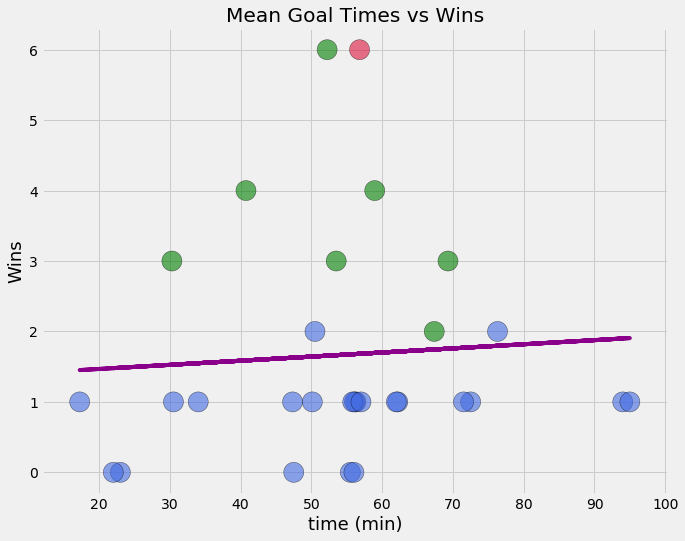

R-value: 0.06821426764078717, P-value: 0.7202185945329513)


In [9]:
# get plt style
plt.style.use('fivethirtyeight')
merged_df['colors'] = 'royalblue'
fig, ax = plt.subplots(figsize = (10,8))


slope, intercept, r_value, p_value, std_err = scipy.linregress(merged_df["combined_avg"], team_wins)

z = np.polyfit(merged_df["combined_avg"], team_wins, 1)
p = np.poly1d(z)

# set title and axis labels
plt.ylabel("Wins", fontsize=18)
plt.xlabel("time (min)", fontsize=18)
plt.title("Time Data vs. Wins", color = "black")

# isolate France and make crimson
merged_df.loc[merged_df["country"]=="France",'colors'] = 'crimson'

# color remaining top 8 teams green
merged_df.loc[merged_df["country"] == "Russia", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "Croatia", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "Uruguay", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "Sweden", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "England", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "Brazil", 'colors'] = "g"
merged_df.loc[merged_df["country"] == "Belgium", 'colors'] = "g"

# plot line
plt.plot(merged_df["combined_avg"],p(merged_df["combined_avg"]),"darkmagenta")

# plot scatter plot
plt.scatter(merged_df["combined_avg"],team_wins, color = merged_df.colors,
            marker = "o",
            s = 400,
            edgecolors = "black",
            alpha = .6
           )



# set title and axis labels
plt.ylabel("Wins", fontsize=18)
plt.xlabel("time (min)", fontsize=18)
plt.title("Mean Goal Times vs Wins", color = "black")

plt.savefig("Mean Goal Times vs Wins FIFA 2018.png")
plt.show()

# print r and p value
print(f"R-value: {r_value}, P-value: {p_value})")

# plt.savefig("TimeVsWin.jpg",orientation='landscape',format="jpg",dpi=1000)